<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/mec647_Elast_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [3]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401

# The problem of elasticity


Let $\Omega \subset (0, L)^n$, with $L$ finite, and consider the energy $E(u)$ defined as
$$
E(u)=\frac{1}{2}\int_\Omega A e(u): e(u) dx - \int_\Omega f.u dx$$
we solve:
$$min \left\{ E(u):  u \in V_t\right\}$$ with $ V_t : H^1(\Omega, R^n)$ plus boundary conditions. 

From a mechanical  standpoint, 
From a mathematical standpoint,

Boundary conditions are such that equilibrium

The interest of the above is that $E(u)$ ...


In [8]:
# library include


import numpy as np
import yaml
import json
import sys
import os
from pathlib import Path

from mpi4py import MPI

import petsc4py
from petsc4py import PETSc

import dolfinx
import dolfinx.plot
from dolfinx import log
import ufl


from dolfinx.io import XDMFFile

import logging

logging.basicConfig(level=logging.INFO)

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)


In [14]:
try:
  !git clone https://github.com/kumiori/mec647.git
except:
  pass

Cloning into 'mec647'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 358 (delta 157), reused 90 (delta 29), pack-reused 0
Receiving objects: 100% (358/358), 6.11 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [7]:
sys.path.append('mec647/')


In [67]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.1
    },
    'model': {
        'mu': 1.,
        'lmbda': 0.
    },
    'solvers': {
        'snes': {
            'snes_type': 'newtontr',
            'snes_stol': 1e-8,
            'snes_atol': 1e-8,
            'snes_rtol': 1e-8,
            'snes_max_it': 100,
            'snes_monitor': "",
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps'
        }
    }
}

# parameters.get('loading')



In [17]:
!{sys.executable} -m pip install gmsh

['Requirement already satisfied: gmsh in /usr/local/lib/python3.7/dist-packages (4.9.3)']

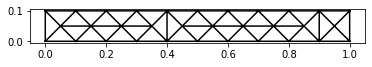

In [69]:
# Mesh
Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]


import meshes
dir(meshes)

from meshes import primitives

gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    0.1, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)

# TODO: Plot mesh


plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")


In [70]:
# Functional setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)
V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 

u = dolfinx.fem.Function(V_u, name="Displacement")
g = dolfinx.fem.Function(V_u, name="Body pressure")

u_ = dolfinx.fem.Function(V_u, name="Boundary Displacement")
# ux_ = dolfinx.fem.Function(V_u.sub(0).collapse(), name="Boundary Displacement")




In [71]:
# Integral measures
dx = ufl.Measure("dx", domain=mesh)
ds = ufl.Measure("ds", domain=mesh)





In [57]:

# Data

zero = Function(V_u)
# works in parallel!
with zero.vector.localForm() as loc:
    loc.set(0.0)

one = Function(V_u)
# works in parallel!
with one.vector.localForm() as loc:
    loc.set(1.0)

g = Function(V_u)
# works in parallel!
with zero.vector.localForm() as loc:
    loc.set(0.0)


In [72]:
# energy
mu = parameters["model"]["mu"]
lmbda = parameters["model"]["lmbda"]

def _e(u):
  return ufl.sym(ufl.grad(u))

en_density = 1/2 * (2*mu* ufl.inner(_e(u),_e(u))) + lmbda*ufl.tr(_e(u))**2
energy = en_density * dx - ufl.dot(g, u) * dx

In [73]:
# boundary conditions

def left(x):
  return np.isclose(x[0], 0.)

def right(x):
  return np.isclose(x[0], Lx)

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                left_facets)


# right side

right_facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, right)
right_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                right_facets)






In [74]:

bcs = [dirichletbc(zero, left_dofs), dirichletbc(one, right_dofs)]
bcs

In [75]:
left_dofs

array([30, 31], dtype=int32)

In [78]:

# solving
from solvers import SNESSolver
D_energy_u = ufl.derivative(energy, u, ufl.TestFunction(V_u))

problem = SNESSolver(
    D_energy_u,
    u,
    bcs,
    bounds=None,
    petsc_options=parameters.get("solvers").get("snes"),
    prefix="elast",
)


solver.solve()


VerificationError: ignored

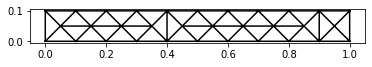

In [66]:
# visualisation
from utils import viz
import matplotlib.pyplot as plt
from utils.viz import plot_mesh, plot_vector, plot_scalar


plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

# postprocessing
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

    _plt = plot_scalar(u_.sub(0), plotter, subplot=(0, 0))

    _plt = plot_vector(u, plotter, subplot=(0, 1))

    _plt.screenshot(f"displacement_MPI{comm.size}.png")

In [ ]:
viz.plot_vector()